In [1]:
import numpy as np
from numpy.linalg import matrix_power
import math
import sympy
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise

In [2]:
df = pd.read_csv('data1.csv')
df

,GPS Time,Device Time,Longitude,Latitude,GPS Speed (Meters/second),Horizontal Dilution of Precision,Altitude,Bearing,G(x),G(y),G(z),G(calibrated),Engine RPM(rpm),Speed (OBD)(km/h),Acceleration Sensor(Total)(g),Litres Per 100 Kilometer(Instant)(l/100km),Speed (GPS)(km/h),Acceleration Sensor(Z axis)(g)
0,Fri Mar 25 17:18:15 GMT+03:00 2016,25-Mar-2016 17:18:08.672,37.583105,55.848558,1.0,14.0,143.0,0.0,-1.069122,8.187592,4.949341,0.002015,-,0.0,0.002015,-,3.5999999046325684,0.405627
1,Fri Mar 25 17:18:16 GMT+03:00 2016,25-Mar-2016 17:18:08.767,37.583102,55.848554,1.0,14.0,143.0,0.0,-1.529938,8.353485,5.078201,0.027657,-,0.0,0.027657,-,3.5999999046325684,0.417656
2,Fri Mar 25 17:18:16 GMT+03:00 2016,25-Mar-2016 17:18:08.867,37.583102,55.848554,1.0,14.0,143.0,0.0,-1.483780,8.233429,4.653717,0.016112,-,0.0,0.016112,-,3.5999999046325684,0.374385
3,Fri Mar 25 17:18:16 GMT+03:00 2016,25-Mar-2016 17:18:08.966,37.583102,55.848554,1.0,14.0,143.0,0.0,-1.489288,8.442078,4.666107,0.015226,-,0.0,0.015226,-,3.5999999046325684,0.375648
4,Fri Mar 25 17:18:16 GMT+03:00 2016,25-Mar-2016 17:18:09.067,37.583102,55.848554,1.0,14.0,143.0,0.0,-0.720825,8.725891,4.743317,0.034077,-,0.0,0.034077,-,3.5999999046325684,0.383519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22276,Fri Mar 25 17:55:28 GMT+03:00 2016,25-Mar-2016 17:55:21.259,37.525679,55.738373,0.0,4.0,166.0,0.0,0.998703,9.563507,1.149261,0.006151,599.5,0.0,0.006151,-,0.0,0.017152
22277,Fri Mar 25 17:55:28 GMT+03:00 2016,25-Mar-2016 17:55:21.358,37.525679,55.738373,0.0,4.0,166.0,0.0,1.070480,9.641998,1.154083,0.006844,601.25,0.0,0.006844,-,0.0,0.017644
22278,Fri Mar 25 17:55:28 GMT+03:00 2016,25-Mar-2016 17:55:21.458,37.525679,55.738373,0.0,4.0,166.0,0.0,1.026428,9.537384,1.169113,0.006450,601.25,0.0,0.006450,-,0.0,0.019176
22279,Fri Mar 25 17:55:28 GMT+03:00 2016,25-Mar-2016 17:55:21.557,37.525679,55.738373,0.0,4.0,166.0,0.0,0.681564,8.894714,1.603546,-0.057069,609.0,0.0,-0.057069,-,0.0,0.063460


In [3]:
# Достаем данные из таблицы

time_GPS = df.iloc[:, 0].values.tolist()
time_OBD = df.iloc[:, 1].values.tolist()
time_GPS = [x[11:19] for x in time_GPS]
time_OBD = [x[12:] for x in time_OBD]
time_GPS = [int(x[:2])*3600 + int(x[3:5])*60 + int(x[6:]) - 62295 for x in time_GPS] # перевод в секунды
time_OBD = [int(x[:2])*3600 + int(x[3:5])*60 + float(x[6:]) - 62288.672 for x in time_OBD] # перевод в секунды


Longitude = df.iloc[:, 2].values.tolist() # думаю, что это x
Latitude = df.iloc[:, 3].values.tolist() # думаю, что это y
Longitude = [float(x) * 63.995 * 1000 - 2405130.8281531497 for x in Longitude] # перевод в метры (не уверен)
Latitude = [float(x) * 111.1 * 1000 - 6204774.826019 for x in Latitude] # перевод в метры (не уверен)

speed_OBD = df.iloc[:, 13].values.tolist() # km/h
speed_GPS = df.iloc[:, 16].values.tolist() # km/h

speed_OBD = [float(x) * 1000 / 3600 for x in speed_OBD]
speed_GPS = [float(x) * 1000 / 3600 if x != '-' else 0 for x in speed_GPS] # '-' мб надо оставить

Bearing = df.iloc[:, 7].values.tolist()
Bearing = [float(x) * math.pi/180 for x in Bearing]

In [6]:
# Разбиение скоростей на x, y

speed_OBD_x = np.array([])
speed_OBD_y = np.array([])

speed_GPS_x = np.array([])
speed_GPS_y = np.array([])

X_OBD = np.array([])
Y_OBD = np.array([])

# x = x0 + Vdt
# xk = xk-1 + vxk-1 * dt

x_OBD = Longitude[0]
y_OBD = Latitude[0]

for i in range(len(Bearing)):
    V = speed_GPS[i]
    Vx = V * np.sin(Bearing[i])
    Vy = V * np.cos(Bearing[i])
    speed_GPS_x = np.append(speed_GPS_x, Vx)
    speed_GPS_y = np.append(speed_GPS_y, Vy)

    V = speed_OBD[i]
    Vx = V * np.sin(Bearing[i])
    Vy = V * np.cos(Bearing[i])
    speed_OBD_x = np.append(speed_OBD_x, Vx)
    speed_OBD_y = np.append(speed_OBD_y, Vy)
    x_OBD = x_OBD + speed_OBD_x[i] * 0.1
    y_OBD = y_OBD + speed_OBD_y[i] * 0.1
    X_OBD = np.append(X_OBD, x_OBD)
    Y_OBD = np.append(Y_OBD, y_OBD)
    

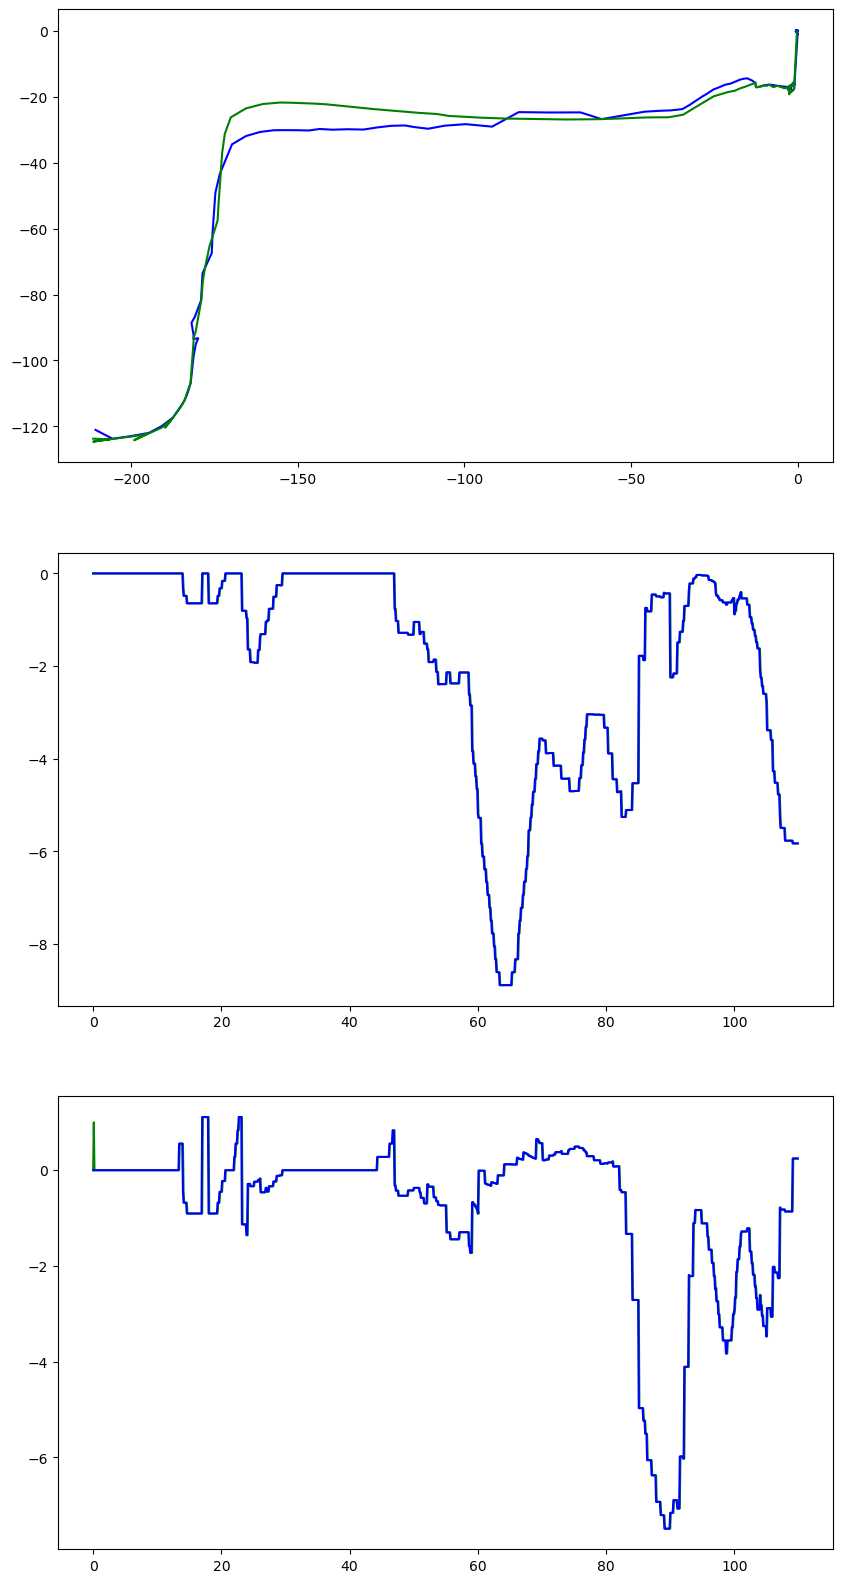

In [7]:
dt_GPS = 1
dt_OBD = 0.1

# Проподание GPS:
t1 = 17 * 3600 + 25 * 60 - 62295 # 17:25
t2 = 17 * 3600 + 35 * 60 - 62295 # 17:35

F_GPS = np.array([[1, 0, dt_GPS, 0],  # x
                  [0, 1, 0, dt_GPS],  # y
                  [0, 0, 1, 0],  # x*
                  [0, 0, 0, 1]]) # y*

F_OBD = np.array([[1, 0, dt_OBD, 0],  # x
                  [0, 1, 0, dt_OBD],  # y
                  [0, 0, 1, 0],  # x*
                  [0, 0, 0, 1]]) # y*

B = np.array([[1, 0, 0, 0],  # x
              [0, 1, 0, 0],  # y
              [0, 0, 1, 0],  # x*
              [0, 0, 0, 1]]) # y*


Q = np.array([[100, 0, 0, 0],  # x
              [0, 100, 0, 0],  # y
              [0, 0, 100, 0],  # x*
              [0, 0, 0, 100]]) # y*

P_k = np.eye(4) * 1000
Hk = np.eye(4)


Rk = np.eye(4) * 0.1
Rk = np.array([[1, 0, 0, 0],  # x
               [0, 1, 0, 0],  # y
               [0, 0, 1, 0],  # x*
               [0, 0, 0, 1]]) * 0.1# y*

Hk_OBD = np.array([[1, 0, -0.1, 0],  # x
                   [0, 1, 0, -0.1],  # y
                   [0, 0, 1, 0],  # x*
                   [0, 0, 0, 1]]) # y*

def predict(current, previous, P_k, F):
    global Q, B
    x, y, vx, vy = current
    x_p, y_p, vx_p, vy_p = previous
    X = np.array([x, y, vx, vy])
    U = np.array([x - x_p, y - y_p, vx - vx_p, vy - vy_p])
    
    X_k = F @ X + B @ U
    P_k = F @ P_k @ F.T + Q
    
    return X_k, P_k


def update(current, X_k, P_k, Hk):
    global Rk
    Zk = current # текущее состояние датчиков
    
    Yk = Zk - Hk @ X_k
    Kk = (P_k @ Hk.T) @ matrix_power((Hk @ P_k @ Hk.T + Rk), -1) 
    Xk = X_k + Kk @ Yk 
    Pk = P_k - Kk @ Hk @ P_k
    
    return Xk, Pk


coord = np.array([[0, 0]])
speed = np.array([0, 0])
i = 1

while i < 1100:
    if Bearing[i] == 0 or (i > t1 and i < t2):
        move = False
    else:
        move = True
    if (i % 10 == 0 and move) or i == 1:
        current_GPS = np.array([Longitude[i], Latitude[i], speed_GPS_x[i], speed_GPS_y[i]])
        previous_GPS = np.array([coord[i-1][0], coord[i-1][1], speed_GPS_x[i-1], speed_GPS_y[i-1]])
        X_k, P_k = predict(current_GPS, previous_GPS, P_k, F_GPS)
        X_k, P_k = update(current_GPS, X_k, P_k, Hk)
    
    if i > 1:
#         print(i, X_k, coord[i-2][0], coord[i-2][1])
        current_OBD = np.array([X_k[0], X_k[1], speed_OBD_x[i-1], speed_OBD_y[i-1]])
        previous_OBD = np.array([coord[i-2][0], coord[i-2][1], speed_OBD_x[i-2], speed_OBD_y[i-2]])
        X_k, P_k = predict(current_OBD, previous_OBD, P_k, F_OBD)
        X_k, P_k = update(current_OBD, X_k, P_k, Hk_OBD)
    
    coord = np.append(coord, [X_k[0], X_k[1]])
    coord = coord.reshape(-1, 2)
    speed = np.append(speed, [X_k[2], X_k[3]])
    i += 1
    
coord = coord.reshape(-1, 2)
coord_x = [i[0] for i in coord]
coord_y = [i[1] for i in coord]

speed = speed.reshape(-1, 2)
speed_x = [i[0] for i in speed]
speed_y = [i[1] for i in speed]

a = 0

plt.figure(figsize=(10, 20))

plt.subplot(311)
plt.plot(Longitude[a:i], Latitude[a:i], c='b')
plt.plot(coord_x[a+1:i], coord_y[a+1:i], c='g')

plt.subplot(312)
plt.plot(time_OBD[a:i], speed_x[a:i], c='g')
plt.plot(time_OBD[a:i], speed_OBD_x[a:i], c='b')

plt.subplot(313)
plt.plot(time_OBD[a:i], speed_y[a:i], c='g')
plt.plot(time_OBD[a:i], speed_OBD_y[a:i], c='b')

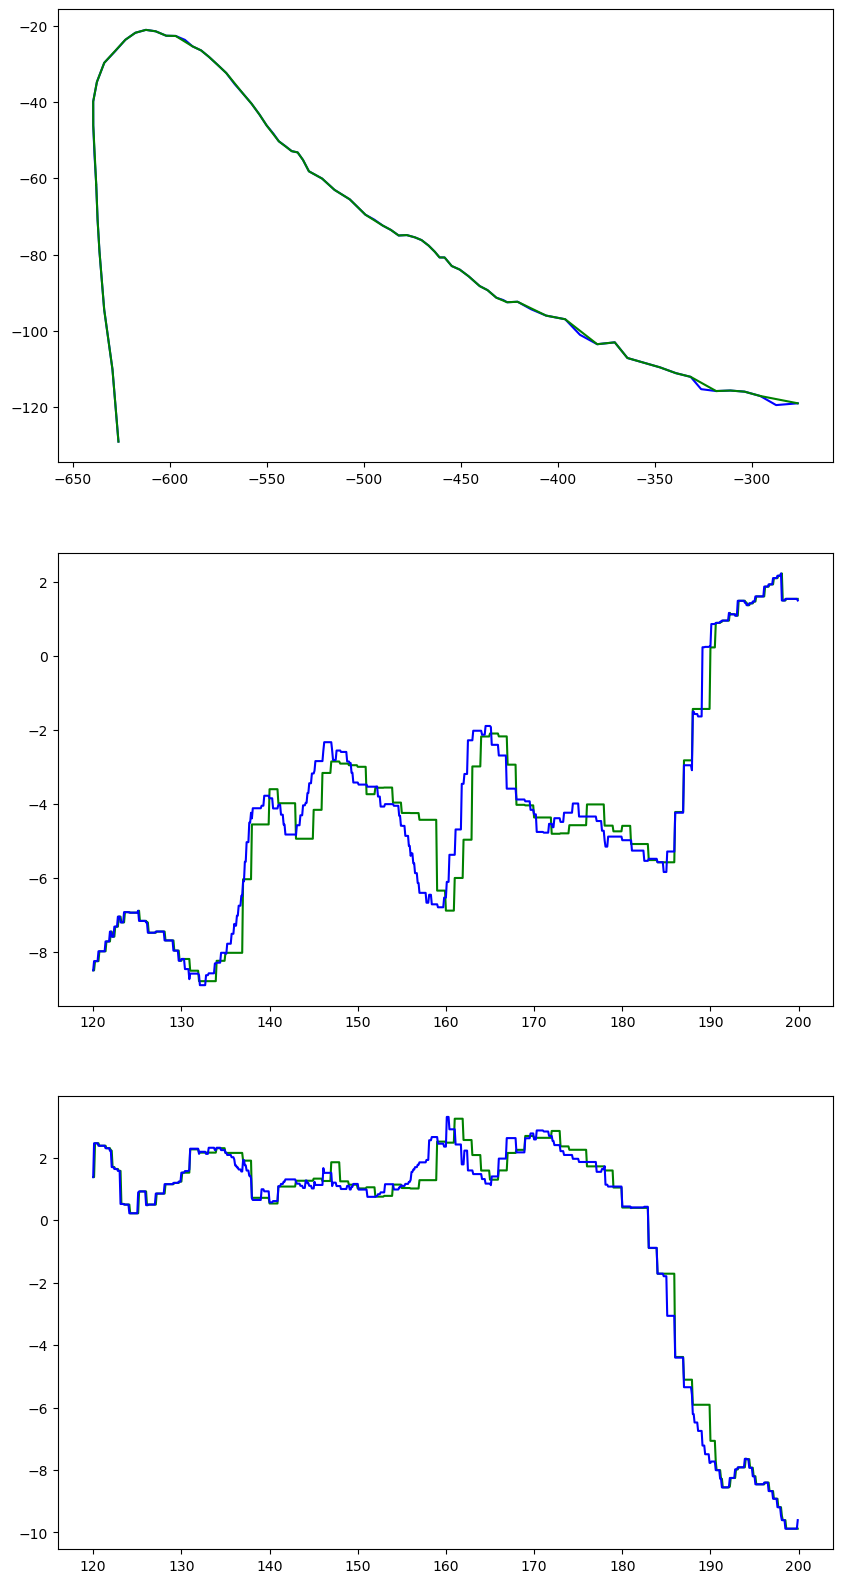

In [8]:
dt_GPS = 1
dt_OBD = 0.1

# Проподание GPS:
t1 = 17 * 3600 + 40 * 60 - 62295 # 17:25
t2 = 17 * 3600 + 50 * 60 - 62295 # 17:35

F_GPS = np.array([[1, 0, dt_GPS, 0],  # x
                  [0, 1, 0, dt_GPS],  # y
                  [0, 0, 1, 0],  # x*
                  [0, 0, 0, 1]]) # y*

F_OBD = np.array([[1, 0, dt_OBD, 0],  # x
                  [0, 1, 0, dt_OBD],  # y
                  [0, 0, 1, 0],  # x*
                  [0, 0, 0, 1]]) # y*

B = np.array([[0, 0, 0, 0],  # x
              [0, 0, 0, 0],  # y
              [0, 0, 0, 0],  # x*
              [0, 0, 0, 0]]) # y*


Q = np.array([[100, 0, 0, 0],  # x
              [0, 100, 0, 0],  # y
              [0, 0, 100, 0],  # x*
              [0, 0, 0, 100]]) # y*

P_k = np.eye(4) * 1000
Hk = np.eye(4)
Hk_OBD = np.array([[1, 0, 0, 0],  # x
                   [0, 1, 0, 0],  # y
                   [0, 0, 1, 0],  # x*
                   [0, 0, 0, 1]]) # y*

Rk = np.eye(4) * 0.1


def predict(current, previous, P_k, F):
    global Q, B
    x, y, vx, vy = current
    x_p, y_p, vx_p, vy_p = previous
    X = np.array([x, y, vx, vy])
    U = np.array([x - x_p, y - y_p, vx - vx_p, vy - vy_p])
    
    X_k = F @ X + B @ U
    P_k = F @ P_k @ F.T + Q
    
    return X_k, P_k


def update(current, X_k, P_k, Hk):
    global Rk
    Zk = current # текущее состояние датчиков
    
    Yk = Zk - Hk @ X_k
    Kk = (P_k @ Hk.T) @ matrix_power((Hk @ P_k @ Hk.T + Rk), -1) 
    Xk = X_k + Kk @ Yk 
    Pk = P_k - Kk @ Hk @ P_k
    
    return Xk, Pk


coord = np.array([[0, 0]])
speed = np.array([0, 0])
i = 1

while i < 2000:
    if Bearing[i] == 0:
        move = False
    else:
        move = True
    if (i % 10 == 0 and move) or i == 1:
        current_GPS = np.array([Longitude[i], Latitude[i], speed_GPS_x[i], speed_GPS_y[i]])
        previous_GPS = np.array([coord[i-1][0], coord[i-1][1], speed_GPS_x[i-1], speed_GPS_y[i-1]])
        X_k, P_k = predict(current_GPS, previous_GPS, P_k, F_GPS)
        X_k, P_k = update(current_GPS, X_k, P_k, Hk)
    
    if i > 1 and (i < t1 or i > t2):
        current_OBD = np.array([X_k[0], X_k[1], speed_OBD_x[i-1], speed_OBD_y[i-1]])
        previous_OBD = np.array([coord[i-2][0], coord[i-2][1], speed_OBD_x[i-2], speed_OBD_y[i-2]])
        X_k, P_k = predict(current_OBD, previous_OBD, P_k, F_OBD)
        X_k, P_k = update(current_OBD, X_k, P_k, Hk_OBD)
    
    coord = np.append(coord, [X_k[0], X_k[1]])
    coord = coord.reshape(-1, 2)
    speed = np.append(speed, [X_k[2], X_k[3]])
    i += 1
    
coord = coord.reshape(-1, 2)
coord_x = [i[0] for i in coord]
coord_y = [i[1] for i in coord]

speed = speed.reshape(-1, 2)
speed_x = [i[0] for i in speed]
speed_y = [i[1] for i in speed]

a = 1200

plt.figure(figsize=(10, 20))

plt.subplot(311)
plt.plot(Longitude[a:i], Latitude[a:i], c='b')
plt.plot(coord_x[a+1:i], coord_y[a+1:i], c='g')

plt.subplot(312)
plt.plot(time_OBD[a:i], speed_x[a:i], c='g')
plt.plot(time_OBD[a:i], speed_OBD_x[a:i], c='b')

plt.subplot(313)
plt.plot(time_OBD[a:i], speed_y[a:i], c='g')
plt.plot(time_OBD[a:i], speed_OBD_y[a:i], c='b')

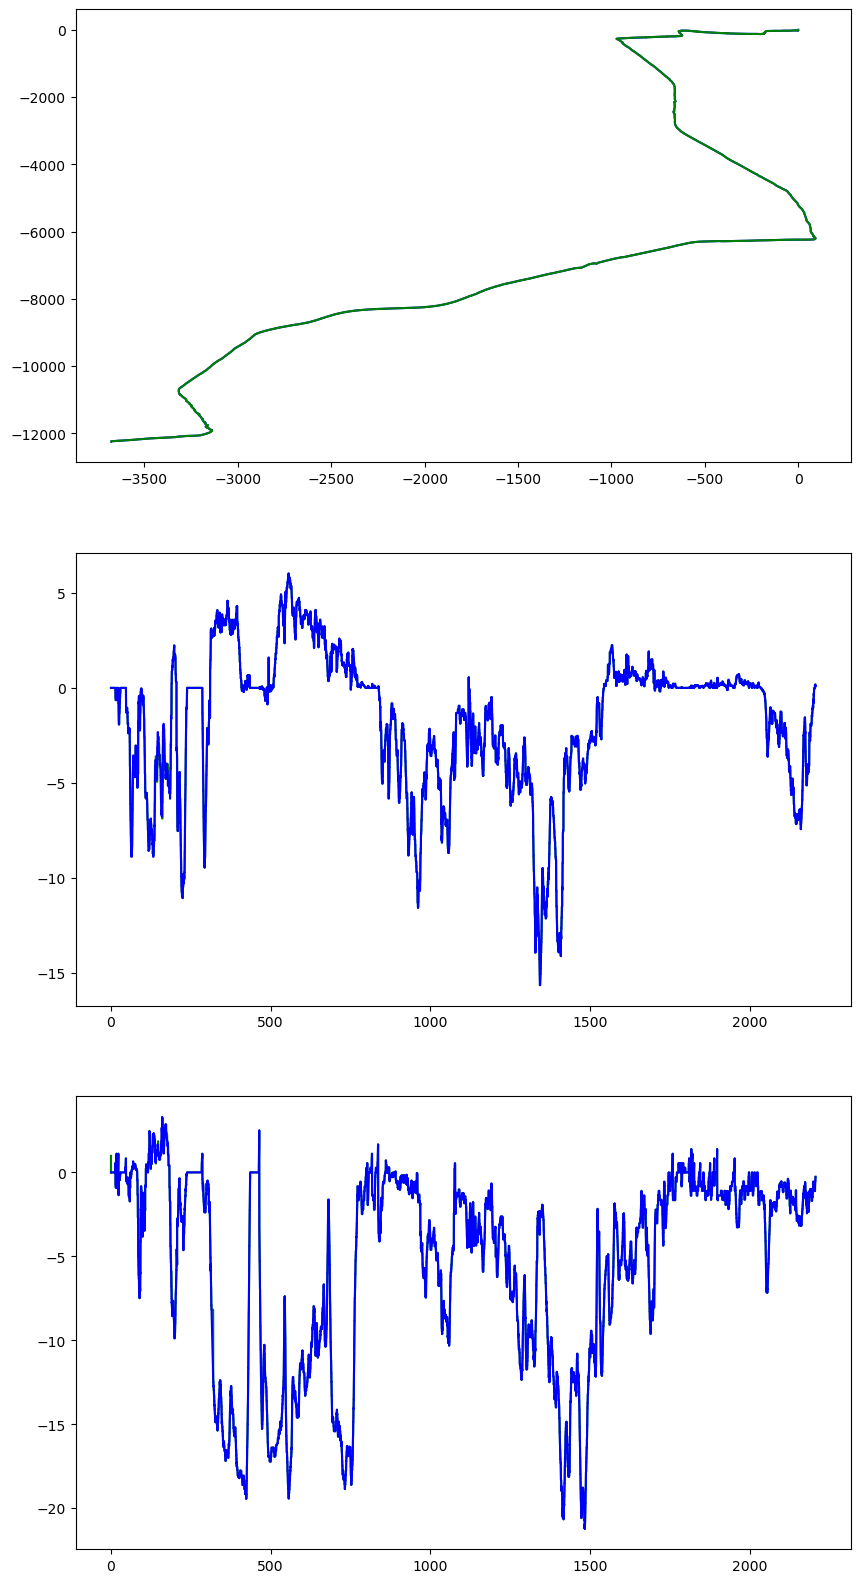

In [9]:
dt_GPS = 1
dt_OBD = 0.1

# Проподание GPS:
t1 = 17 * 3600 + 40 * 60 - 62295 # 17:25
t2 = 17 * 3600 + 50 * 60 - 62295 # 17:35

F_GPS = np.array([[1, 0, dt_GPS, 0],  # x
                  [0, 1, 0, dt_GPS],  # y
                  [0, 0, 1, 0],  # x*
                  [0, 0, 0, 1]]) # y*

F_OBD = np.array([[1, 0, dt_OBD, 0],  # x
                  [0, 1, 0, dt_OBD],  # y
                  [0, 0, 1, 0],  # x*
                  [0, 0, 0, 1]]) # y*

B = np.array([[1, 0, 0, 0],  # x
              [0, 1, 0, 0],  # y
              [0, 0, 1, 0],  # x*
              [0, 0, 0, 1]]) # y*


Q = np.array([[100, 0, 0, 0],  # x
              [0, 100, 0, 0],  # y
              [0, 0, 100, 0],  # x*
              [0, 0, 0, 100]]) # y*

P_k = np.eye(4) * 1000
Hk = np.eye(4)
Hk_OBD = np.array([[1, 0, 0, 0],  # x
                   [0, 1, 0, 0],  # y
                   [0, 0, 1, 0],  # x*
                   [0, 0, 0, 1]]) # y*

Rk = np.eye(4) * 0.1
# Rk = np.array([[1, 0, 1, 0],  # x
#                [0, 1, 0, 1],  # y
#                [0, 0, 1, 0],  # x*
#                [0, 0, 0, 1]]) * 0.1# y*


def predict(current, previous, P_k, F):
    global Q, B
    x, y, vx, vy = current
    x_p, y_p, vx_p, vy_p = previous
    X = np.array([x, y, vx, vy])
    U = np.array([x - x_p, y - y_p, vx - vx_p, vy - vy_p])
    
    X_k = F @ X + B @ U
    P_k = F @ P_k @ F.T + Q
    
    return X_k, P_k


def update(current, X_k, P_k, Hk):
    global Rk
    Zk = current # текущее состояние датчиков
    
    Yk = Zk - Hk @ X_k
    Kk = (P_k @ Hk.T) @ matrix_power((Hk @ P_k @ Hk.T + Rk), -1) 
    Xk = X_k + Kk @ Yk 
    Pk = P_k - Kk @ Hk @ P_k
    
    return Xk, Pk


coord = np.array([[0, 0]])
speed = np.array([0, 0])
i = 1

while i < 22000:
    if Bearing[i] == 0:
        move = False
    else:
        move = True
    if (i % 10 == 0 and move) or i == 1:
        current_GPS = np.array([Longitude[i], Latitude[i], speed_GPS_x[i], speed_GPS_y[i]])
        previous_GPS = np.array([coord[i-1][0], coord[i-1][1], speed_GPS_x[i-1], speed_GPS_y[i-1]])
        X_k, P_k = predict(current_GPS, previous_GPS, P_k, F_GPS)
        X_k, P_k = update(current_GPS, X_k, P_k, Hk)
    
    if i > 1 and (i < t1 or i > t2):
#         print(i, X_k, coord[i-2][0], coord[i-2][1])
        current_OBD = np.array([X_k[0], X_k[1], speed_OBD_x[i-1], speed_OBD_y[i-1]])
        previous_OBD = np.array([coord[i-2][0], coord[i-2][1], speed_OBD_x[i-2], speed_OBD_y[i-2]])
        X_k, P_k = predict(current_OBD, previous_OBD, P_k, F_OBD)
        X_k, P_k = update(current_OBD, X_k, P_k, Hk_OBD)
    
    coord = np.append(coord, [X_k[0], X_k[1]])
    coord = coord.reshape(-1, 2)
    speed = np.append(speed, [X_k[2], X_k[3]])
    i += 1
    
# print(X_k)
# print()
# print(P_k)
coord = coord.reshape(-1, 2)
coord_x = [i[0] for i in coord]
coord_y = [i[1] for i in coord]

speed = speed.reshape(-1, 2)
speed_x = [i[0] for i in speed]
speed_y = [i[1] for i in speed]
# print(coord[:100])

a = 0

plt.figure(figsize=(10, 20))

plt.subplot(311)
plt.plot(Longitude[a:i], Latitude[a:i], c='b')
plt.plot(coord_x[a+1:i], coord_y[a+1:i], c='g')

plt.subplot(312)
plt.plot(time_OBD[a:i], speed_x[a:i], c='g')
plt.plot(time_OBD[a:i], speed_OBD_x[a:i], c='b')

plt.subplot(313)
plt.plot(time_OBD[a:i], speed_y[a:i], c='g')
plt.plot(time_OBD[a:i], speed_OBD_y[a:i], c='b')